# Music Popularity Prediction for Live performances and Tours Using AI

## Introduction
Musicians often face the challenge of selecting which songs to perform live during concerts or on tours. Choosing the right setlist can significantly impact audience engagement, satisfaction, and even revenue from concerts. This project aims to provide musicians and their teams with a data-driven solution to identify which songs are most likely to resonate with their audience in specific locations or during particular events.

Leveraging machine learning and data analytics, this tool will analyze various factors such as streaming data, social media mentions, fan requests, and previous performance metrics. By doing so, it can suggest songs that are likely to generate a positive response, helping artists optimize their setlists for different locations and tour events.


## Data Cleaning and Preprocessing

First I'll load and clean the dataset by addressing missing values, then i'll convert numeric columns stored as strings into appropriate numeric types, and creating a binary target variable that reflects the potential popularity of each song.


In [5]:
# Imports I used for my project
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping


In [6]:
# Load the dataset
file_path = "/content/top_songs.csv"
data = pd.read_csv(file_path, encoding='ISO-8859-1')

In [7]:
# Cleaning the numeric columns stored as strings (removing commas and convert to numbers)
numeric_cols = ['Spotify Streams', 'Spotify Playlist Count', 'Spotify Playlist Reach',
                'YouTube Views', 'YouTube Likes', 'TikTok Posts', 'TikTok Likes', 'TikTok Views',
                'YouTube Playlist Reach', 'AirPlay Spins', 'SiriusXM Spins',
                'Deezer Playlist Reach', 'Pandora Streams', 'Pandora Track Stations',
                'Soundcloud Streams', 'Shazam Counts']
#remove the commas
for col in numeric_cols:
    data[col] = data[col].str.replace(',', '').astype(float)



In [8]:
# Drop entirely null columns
data.drop(columns=['TIDAL Popularity'], inplace=True)

### Check for Missing Values

In [9]:
# Check for missing values in the dataset
missing_values = data.isnull().sum()
print("Missing Values Before Imputation:\n", missing_values)

# Fill missing values with column means for numeric columns
data.fillna(data.mean(numeric_only=True), inplace=True)

# Fill missing values in the 'Artist' column with 'Unknown'
data['Artist'].fillna('Unknown', inplace=True)

# Check for any remaining missing values after imputation
missing_values_after = data.isnull().sum()
print("Missing Values After Imputation:\n", missing_values_after)


Missing Values Before Imputation:
 Track                            0
Album Name                       0
Artist                           5
Release Date                     0
ISRC                             0
All Time Rank                    0
Track Score                      0
Spotify Streams                113
Spotify Playlist Count          70
Spotify Playlist Reach          72
Spotify Popularity             804
YouTube Views                  308
YouTube Likes                  315
TikTok Posts                  1173
TikTok Likes                   980
TikTok Views                   981
YouTube Playlist Reach        1009
Apple Music Playlist Count     561
AirPlay Spins                  498
SiriusXM Spins                2123
Deezer Playlist Count          921
Deezer Playlist Reach          928
Amazon Playlist Count         1055
Pandora Streams               1106
Pandora Track Stations        1268
Soundcloud Streams            3333
Shazam Counts                  577
Explicit Track      

<ipython-input-9-be9c3f405e8f>:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['Artist'].fillna('Unknown', inplace=True)


### Creating Binary Target Column

Im creating a new binary target column called High_Potential, where:

Tracks with a Track Score greater than the median are classified as 1 (High Potential).
Tracks with a Track Score less than or equal to the median are classified as 0 (Low Potential).

In [10]:
# Creating binary target based on 'Track Score' column
track_score_median = data['Track Score'].median()
data['High_Potential'] = np.where(data['Track Score'] > track_score_median, 1, 0)

# Check the distribution of the new target column
print("High_Potential Distribution:\n", data['High_Potential'].value_counts())


High_Potential Distribution:
 High_Potential
0    2306
1    2294
Name: count, dtype: int64


## Feature Engineering and Data Preprocessing


In this section, we define the feature matrix (X) and the target vector (y), and apply scaling to the features to normalize the data.


In [11]:
# Define X (features) and y (target)
X = data.drop(columns=['High_Potential', 'Track', 'Album Name', 'Artist', 'Release Date', 'ISRC', 'All Time Rank'])  # Drop non-relevant columns
y = data['High_Potential']

In [12]:
# Identify categorical columns
categorical_columns = X.select_dtypes(include=['object']).columns

# Apply one-hot encoding to the categorical columns
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
X_encoded = pd.DataFrame(encoder.fit_transform(X[categorical_columns]))

# Restore column names from encoding
X_encoded.columns = encoder.get_feature_names_out(categorical_columns)

# Drop the original categorical columns from the feature matrix
X_numeric = X.drop(columns=categorical_columns)

# Concatenate the encoded categorical columns back with the rest of the numerical columns
X_processed = pd.concat([X_numeric.reset_index(drop=True), X_encoded.reset_index(drop=True)], axis=1)


### Handling NaN values:

In [13]:
# Check for NaN values after encoding
print("NaN values after encoding:\n", X_processed.isnull().sum())

# Fill NaN values with column mean (for numerical columns)
X_processed.fillna(X_processed.mean(numeric_only=True), inplace=True)

# Verify that no NaN values remain
print("NaN values after filling:\n", X_processed.isnull().sum())


NaN values after encoding:
 Track Score                   0
Spotify Streams               0
Spotify Playlist Count        0
Spotify Playlist Reach        0
Spotify Popularity            0
YouTube Views                 0
YouTube Likes                 0
TikTok Posts                  0
TikTok Likes                  0
TikTok Views                  0
YouTube Playlist Reach        0
Apple Music Playlist Count    0
AirPlay Spins                 0
SiriusXM Spins                0
Deezer Playlist Count         0
Deezer Playlist Reach         0
Amazon Playlist Count         0
Pandora Streams               0
Pandora Track Stations        0
Soundcloud Streams            0
Shazam Counts                 0
Explicit Track                0
dtype: int64
NaN values after filling:
 Track Score                   0
Spotify Streams               0
Spotify Playlist Count        0
Spotify Playlist Reach        0
Spotify Popularity            0
YouTube Views                 0
YouTube Likes                 0
TikT

## Feature Scaling

Now, we will scale the features using `MinMaxScaler` to ensure all feature values are between 0 and 1.

In [14]:
# Scaling the features using MinMaxScaler
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_processed)

# Inspect the scaled feature data
print("Scaled Data (First 5 Rows):\n", X_scaled[:5])

Scaled Data (First 5 Rows):
 [[1.00000000e+00 9.12000036e-02 5.20248446e-02 7.49519817e-01
  9.57894737e-01 5.16296653e-03 2.74926861e-02 1.34445201e-01
  2.77566535e-02 2.28625351e-02 2.06588602e-02 2.43589744e-01
  2.30474573e-02 9.62378470e-02 9.66719493e-02 3.65134905e-01
  5.40669856e-01 1.23014193e-02 6.06531602e-03 1.50653464e-02
  1.21443462e-02 0.00000000e+00]
 [7.45750708e-01 7.56055726e-02 4.76159020e-02 6.65528949e-01
  9.57894737e-01 7.12784836e-03 5.59564986e-02 1.57272498e-02
  1.50052007e-03 8.93268196e-04 2.14522132e-02 2.17948718e-01
  2.29366468e-02 2.81809215e-04 1.04595880e-01 2.16242617e-01
  5.26315789e-01 5.31559047e-03 7.52358411e-03 2.07076707e-02
  5.08783335e-03 1.00000000e+00]
 [7.35127479e-01 1.40444413e-01 9.20237605e-02 8.06605607e-01
  9.57894737e-01 7.51087658e-03 3.57673523e-02 7.05221229e-02
  1.17215477e-02 1.44453424e-02 5.12757168e-02 2.20279720e-01
  4.18109922e-02 7.53839651e-02 2.13946117e-01 7.53598900e-01
  8.18181818e-01 3.43163194e-03 1.491

### Data Splitting

Next, we will split the scaled data (X_scaled) and the target (y) into training and testing sets.


In [15]:
# Split the scaled data (X_scaled) and the target (y) into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Verify the sizes of the split datasets
print("Training set size (X_train):", X_train.shape)
print("Testing set size (X_test):", X_test.shape)
print("Training target size (y_train):", y_train.shape)
print("Testing target size (y_test):", y_test.shape)

Training set size (X_train): (3680, 22)
Testing set size (X_test): (920, 22)
Training target size (y_train): (3680,)
Testing target size (y_test): (920,)



## Training the Vanilla Model

In this section, we will define and train a vanilla neural network model without any optimization techniques.


Epoch 1/60
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5597 - loss: 0.6764 - val_accuracy: 0.6875 - val_loss: 0.6022
Epoch 2/60
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7046 - loss: 0.5806 - val_accuracy: 0.7473 - val_loss: 0.5224
Epoch 3/60
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7645 - loss: 0.4986 - val_accuracy: 0.7976 - val_loss: 0.4472
Epoch 4/60
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8000 - loss: 0.4327 - val_accuracy: 0.7989 - val_loss: 0.3943
Epoch 5/60
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8488 - loss: 0.3267 - val_accuracy: 0.8804 - val_loss: 0.2726
Epoch 6/60
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8809 - loss: 0.2878 - val_accuracy: 0.9266 - val_loss: 0.2212
Epoch 7/60
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9158 - loss: 0.2127 - val_accuracy: 0.8261 - val_loss: 0.4004
Epoch 8/60
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9204 - loss: 0.1950 - val_accuracy: 0.9579 - val_loss:

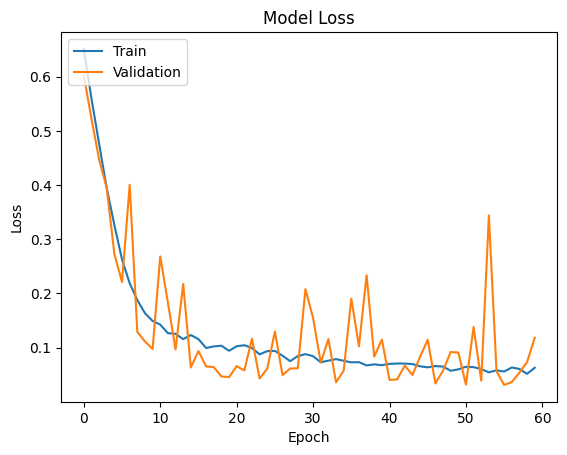

In [49]:
# Define the vanilla model
model = Sequential()

# Input layer
model.add(Dense(128, activation='relu', input_shape=(X_train.shape[1],)))

# Hidden layers
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))

# Output layer (for binary classification)
model.add(Dense(1, activation='sigmoid'))

# Compile the model without optimizer
model.compile(loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, validation_split=0.2, epochs=60, batch_size=32, verbose=1)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)

print("\n ---------------------------------------- \n")
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [50]:
# Save the vanilla model
model.save('Vanilla_model.keras')

## Error Analysis for Vanilla Model

In this section, we will perform error analysis on the vanilla model by generating predictions and calculating evaluation metrics.


29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Confusion Matrix:
 [[445   3]
 [ 42 430]]

Classification Report:
                 precision    recall  f1-score   support

 Low Potential       0.91      0.99      0.95       448
High Potential       0.99      0.91      0.95       472

      accuracy                           0.95       920
     macro avg       0.95      0.95      0.95       920
  weighted avg       0.95      0.95      0.95       920


Model Performance Metrics:
Accuracy: 0.9511
Precision: 0.9931
Recall (Sensitivity): 0.9110
Specificity: 0.9933
F1 Score: 0.9503


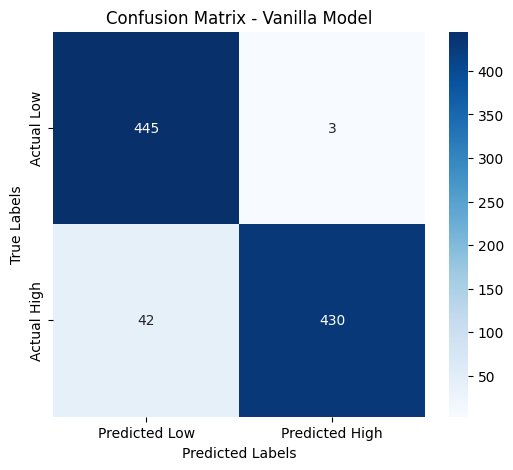

In [55]:

# Step 1: Predictions using the vanilla model on the test set
y_pred = model.predict(X_test)

# Convert predicted probabilities to binary labels (0 or 1) based on a threshold of 0.5
y_pred_labels = (y_pred > 0.5).astype(int)

# Step 2: Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_labels)
print("\nConfusion Matrix:\n", conf_matrix)

# Step 3: Generate a classification report
print("\nClassification Report:\n", classification_report(y_test, y_pred_labels, target_names=['Low Potential', 'High Potential']))

# Step 4: Calculate additional metrics: Accuracy, Precision, Recall, F1 Score
accuracy = accuracy_score(y_test, y_pred_labels)
precision = precision_score(y_test, y_pred_labels)
recall = recall_score(y_test, y_pred_labels)
f1 = f1_score(y_test, y_pred_labels)

# Sensitivity and Specificity
sensitivity = recall  # Recall is the same as sensitivity for binary classification
specificity = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])  # TN / (TN + FP)

# Print the calculated metrics
print(f"\nModel Performance Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall (Sensitivity): {recall:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"F1 Score: {f1:.4f}")

# Step 5: Visualize the confusion matrix as a heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Low', 'Predicted High'], yticklabels=['Actual Low', 'Actual High'])
plt.title('Confusion Matrix - Vanilla Model')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


## L1 Regularization Model
In this section, we will implement L1 regularization to our model and evaluate its performance.


Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


46/46 - 2s - 50ms/step - accuracy: 0.5635 - loss: 0.7810 - val_accuracy: 0.5910 - val_loss: 0.7547
Epoch 2/100
46/46 - 0s - 9ms/step - accuracy: 0.6185 - loss: 0.7240 - val_accuracy: 0.7065 - val_loss: 0.6670
Epoch 3/100
46/46 - 0s - 6ms/step - accuracy: 0.6858 - loss: 0.6552 - val_accuracy: 0.7473 - val_loss: 0.6039
Epoch 4/100
46/46 - 0s - 8ms/step - accuracy: 0.7429 - loss: 0.5900 - val_accuracy: 0.7745 - val_loss: 0.5491
Epoch 5/100
46/46 - 0s - 6ms/step - accuracy: 0.7765 - loss: 0.5369 - val_accuracy: 0.8111 - val_loss: 0.4762
Epoch 6/100
46/46 - 0s - 7ms/step - accuracy: 0.8230 - loss: 0.4602 - val_accuracy: 0.8383 - val_loss: 0.4032
Epoch 7/100
46/46 - 0s - 6ms/step - accuracy: 0.8651 - loss: 0.3783 - val_accuracy: 0.8899 - val_loss: 0.3021
Epoch 8/100
46/46 - 0s - 7ms/step - accuracy: 0.8910 - loss: 0.3218 - val_accuracy: 0.9443 - val_loss: 0.2366
Epoch 9/100
46/46 - 0s - 7ms/step - accuracy: 0.9181 - loss: 0.2686 - val_accuracy: 0.9606 - val_loss: 0.1993
Epoch 10/100
46/46 - 

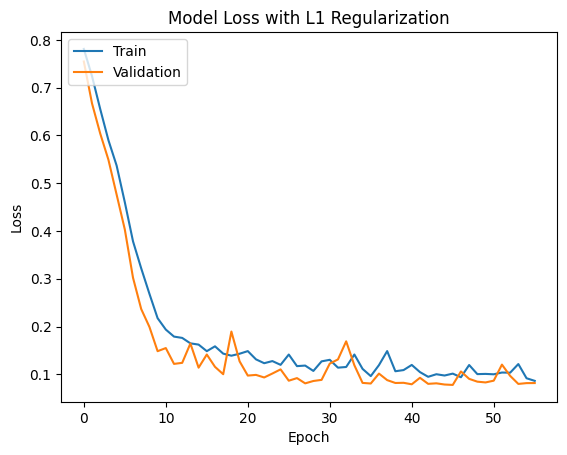

In [18]:
# Build the L1-regularized model
model_l1 = Sequential()

# Input layer
model_l1.add(Dense(128, activation='relu', input_shape=(X_train.shape[1],)))

# First hidden layer with L1 regularization
model_l1.add(Dense(64, activation='relu',
                kernel_regularizer=regularizers.l1(0.0001)))
model_l1.add(Dropout(0.5))

# Second hidden layer with L1 regularization
model_l1.add(Dense(32, activation='relu',
                kernel_regularizer=regularizers.l1(0.0001)))
model_l1.add(Dropout(0.2))

# Third hidden layer with L1 regularization
model_l1.add(Dense(16, activation='relu',
                kernel_regularizer=regularizers.l1(0.0001)))
model_l1.add(Dropout(0.2))

# Output layer with 1 unit and sigmoid activation for binary classification
model_l1.add(Dense(1, activation='sigmoid'))

# Compile the model with Adam optimizer and binary cross-entropy loss
model_l1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Early Stopping to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history_l1 = model_l1.fit(X_train, y_train, epochs=100, validation_split=0.2, batch_size=64,
                    callbacks=[early_stopping], verbose=2)

# Evaluate the model on the test set
test_loss_l1, test_acc_l1 = model_l1.evaluate(X_test, y_test)
print(f"\nTest Loss with L1 Regularization: {test_loss_l1}")
print(f"Test Accuracy with L1 Regularization: {test_acc_l1}")

# Plot training & validation loss values
import matplotlib.pyplot as plt

plt.plot(history_l1.history['loss'])
plt.plot(history_l1.history['val_loss'])
plt.title('Model Loss with L1 Regularization')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [31]:
# Save the L1 Regularization model
model_l1.save('l1_regularized_model.keras')

## Error Analysis for L1 Regularization Model
We will perform error analysis on the L1 model to compare its performance against the vanilla model.


29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 

Confusion Matrix:
 [[440   8]
 [ 14 458]]

Classification Report:
                 precision    recall  f1-score   support

 Low Potential       0.97      0.98      0.98       448
High Potential       0.98      0.97      0.98       472

      accuracy                           0.98       920
     macro avg       0.98      0.98      0.98       920
  weighted avg       0.98      0.98      0.98       920


Model Performance Metrics (L1 Regularization Model):
Accuracy: 0.9761
Precision: 0.9828
Recall (Sensitivity): 0.9703
Specificity: 0.9821
F1 Score: 0.9765


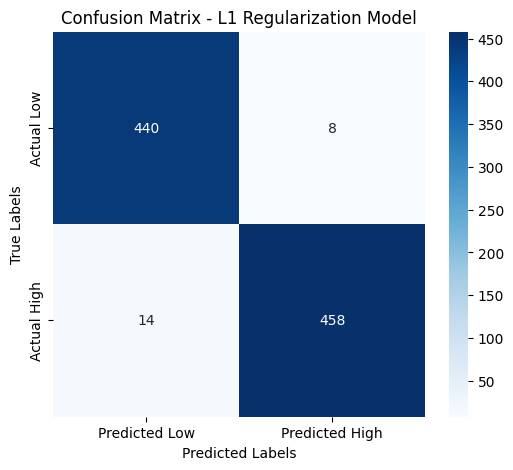

In [54]:
# Make predictions using the L1 regularization model on the test set
y_pred_l1 = model_l1.predict(X_test)

# Convert predicted probabilities to binary labels (0 or 1) based on a threshold of 0.5
y_pred_labels_l1 = (y_pred_l1 > 0.5).astype(int)

# Step 2: Create a confusion matrix
conf_matrix_l1 = confusion_matrix(y_test, y_pred_labels_l1)
print("\nConfusion Matrix:\n", conf_matrix_l1)

# Step 3: Generate a classification report
print("\nClassification Report:\n", classification_report(y_test, y_pred_labels_l1, target_names=['Low Potential', 'High Potential']))

# Step 4: Calculate additional metrics: Accuracy, Precision, Recall, F1 Score
accuracy_l1 = accuracy_score(y_test, y_pred_labels_l1)
precision_l1 = precision_score(y_test, y_pred_labels_l1)
recall_l1 = recall_score(y_test, y_pred_labels_l1)
f1_l1 = f1_score(y_test, y_pred_labels_l1)

# Sensitivity and Specificity
sensitivity_l1 = recall_l1
specificity_l1 = conf_matrix_l1[0, 0] / (conf_matrix_l1[0, 0] + conf_matrix_l1[0, 1])  # TN / (TN + FP)

# Print the calculated metrics
print(f"\nModel Performance Metrics (L1 Regularization Model):")
print(f"Accuracy: {accuracy_l1:.4f}")
print(f"Precision: {precision_l1:.4f}")
print(f"Recall (Sensitivity): {recall_l1:.4f}")
print(f"Specificity: {specificity_l1:.4f}")
print(f"F1 Score: {f1_l1:.4f}")

# Step 5: Visualize the confusion matrix as a heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_l1, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Low', 'Predicted High'], yticklabels=['Actual Low', 'Actual High'])
plt.title('Confusion Matrix - L1 Regularization Model')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


**Plotting the training and validation accuracy and loss**

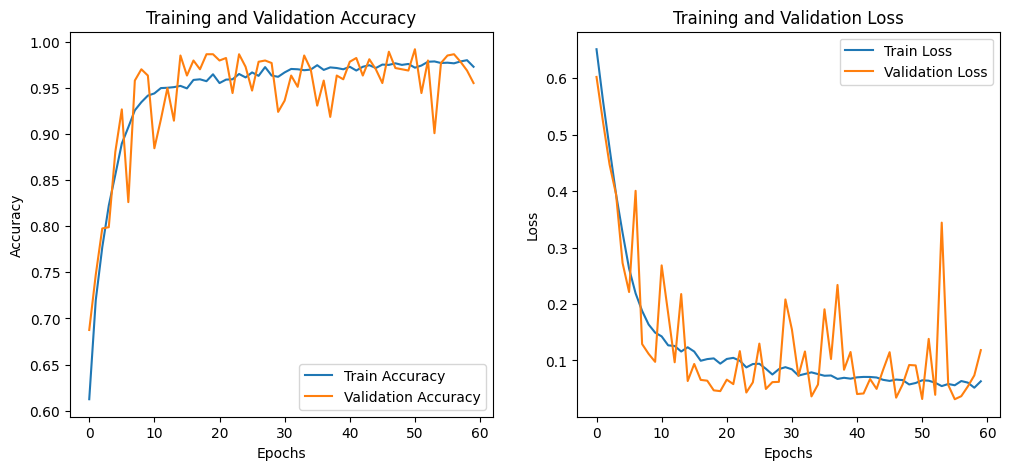

In [53]:
# Plotting the training and validation accuracy and loss
def plot_history(history):
    # Plot accuracy
    plt.figure(figsize=(12, 5))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.show()

# Plot the graphs
plot_history(history)

## L2 Regularized Model with RMSprop Optimizer
We will implement the L2 model. The model will use the RMSprop optimizer.

In [41]:
# Build the L2 Regularized Model
l2_model = Sequential()

# Input layer
l2_model.add(Dense(128, activation='relu', input_shape=(X_train.shape[1],)))

# First hidden layer with L2 regularization
l2_model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.0001)))
l2_model.add(Dropout(0.3))

# Second hidden layer with L2 regularization
l2_model.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.0001)))
l2_model.add(Dropout(0.2))

# Third hidden layer with L2 regularization
l2_model.add(Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.0001)))
l2_model.add(Dropout(0.2))

# Output layer with 1 unit and sigmoid activation (for binary classification)
l2_model.add(Dense(1, activation='sigmoid'))

# Compile the model with RMSprop optimizer and binary cross-entropy loss
l2_model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

# Early stopping to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Message before training starts
print("Training L2 Regularization model...")

# Train the L2 model
l2_history = l2_model.fit(X_train, y_train, epochs=100, validation_split=0.2, batch_size=64,
                          callbacks=[early_stopping], verbose=2)

# Display message after training is complete
print("L2 Regularization model training complete.")

# Evaluate the model on the test set and print results
l2_test_loss, l2_test_acc = l2_model.evaluate(X_test, y_test)
print(f"\nTest Loss (L2 Regularized Model with RMSprop): {l2_test_loss:.4f}")
print(f"Test Accuracy (L2 Regularized Model with RMSprop): {l2_test_acc:.4f}")

Training L2 Regularization model...
Epoch 1/100
46/46 - 2s - 48ms/step - accuracy: 0.5588 - loss: 0.6845 - val_accuracy: 0.6780 - val_loss: 0.6488
Epoch 2/100
46/46 - 0s - 9ms/step - accuracy: 0.6681 - loss: 0.6355 - val_accuracy: 0.6970 - val_loss: 0.6023
Epoch 3/100
46/46 - 0s - 3ms/step - accuracy: 0.7140 - loss: 0.5911 - val_accuracy: 0.7473 - val_loss: 0.5539
Epoch 4/100
46/46 - 0s - 3ms/step - accuracy: 0.7537 - loss: 0.5341 - val_accuracy: 0.7935 - val_loss: 0.5038
Epoch 5/100
46/46 - 0s - 7ms/step - accuracy: 0.7894 - loss: 0.4886 - val_accuracy: 0.8084 - val_loss: 0.4558
Epoch 6/100
46/46 - 0s - 6ms/step - accuracy: 0.8156 - loss: 0.4432 - val_accuracy: 0.8098 - val_loss: 0.4176
Epoch 7/100
46/46 - 0s - 7ms/step - accuracy: 0.8325 - loss: 0.4045 - val_accuracy: 0.8791 - val_loss: 0.3433
Epoch 8/100
46/46 - 0s - 6ms/step - accuracy: 0.8590 - loss: 0.3563 - val_accuracy: 0.9022 - val_loss: 0.2971
Epoch 9/100
46/46 - 0s - 6ms/step - accuracy: 0.8869 - loss: 0.3053 - val_accuracy:

In [42]:
# Save the L2 Regularization model
l2_model.save('l2_regularized_model.keras')



## Plotting Training and Validation Accuracy and Loss
we will visualize the training and validation accuracy and loss over the epochs
to understand the model's performance

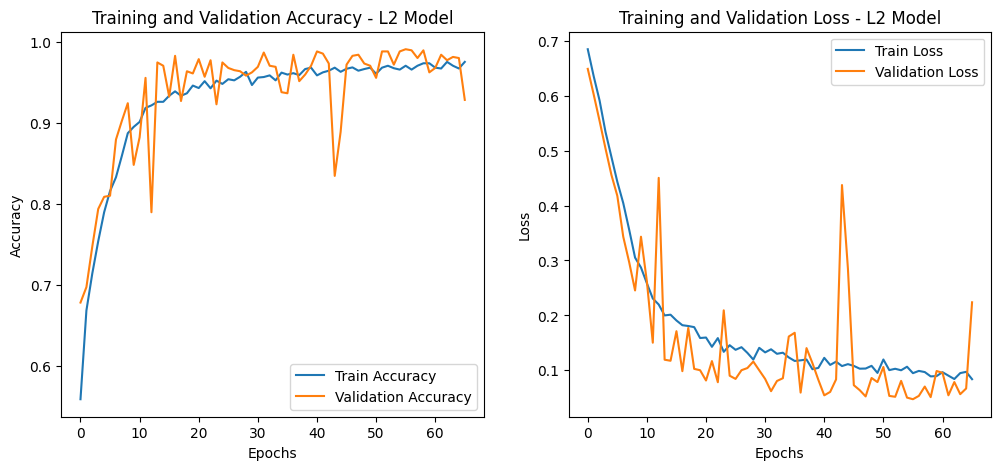

In [51]:
# Function to plot the training and validation accuracy and loss
def plot_l2_history(l2_history):
    # Plot accuracy
    plt.figure(figsize=(12, 5))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(l2_history.history['accuracy'], label='Train Accuracy')
    plt.plot(l2_history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy - L2 Model')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(l2_history.history['loss'], label='Train Loss')
    plt.plot(l2_history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss - L2 Model')
    plt.legend()

    plt.show()

# Plot the graphs
plot_l2_history(l2_history)

## Error Analysis For L2 Model
metrics such as accuracy, precision, recall, F1 score, sensitivity, and specificity will be calculated to see how it compares to the other models.

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Confusion Matrix:
 [[439   9]
 [  7 465]]

Classification Report:
                 precision    recall  f1-score   support

 Low Potential       0.98      0.98      0.98       448
High Potential       0.98      0.99      0.98       472

      accuracy                           0.98       920
     macro avg       0.98      0.98      0.98       920
  weighted avg       0.98      0.98      0.98       920


Model Performance Metrics (L2 Regularization Model):
Accuracy: 0.9826
Precision: 0.9810
Recall (Sensitivity): 0.9852
Specificity: 0.9799
F1 Score: 0.9831


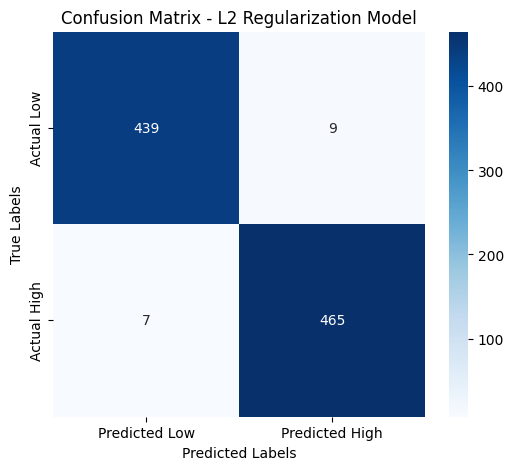

In [52]:
# Make predictions using the L2 regularization model on the test set
y_pred_l2 = l2_model.predict(X_test)

# Convert predicted probabilities to binary labels (0 or 1) based on a threshold of 0.5
y_pred_labels_l2 = (y_pred_l2 > 0.5).astype(int)

# Step 2: Create a confusion matrix
conf_matrix_l2 = confusion_matrix(y_test, y_pred_labels_l2)
print("\nConfusion Matrix:\n", conf_matrix_l2)

# Step 3: Generate a classification report
print("\nClassification Report:\n", classification_report(y_test, y_pred_labels_l2, target_names=['Low Potential', 'High Potential']))

# Step 4: Calculate additional metrics: Accuracy, Precision, Recall, F1 Score
accuracy_l2 = accuracy_score(y_test, y_pred_labels_l2)
precision_l2 = precision_score(y_test, y_pred_labels_l2)
recall_l2 = recall_score(y_test, y_pred_labels_l2)
f1_l2 = f1_score(y_test, y_pred_labels_l2)

# Sensitivity and Specificity
sensitivity_l2 = recall_l2
specificity_l2 = conf_matrix_l2[0, 0] / (conf_matrix_l2[0, 0] + conf_matrix_l2[0, 1])  # TN / (TN + FP)

# Print the calculated metrics
print(f"\nModel Performance Metrics (L2 Regularization Model):")
print(f"Accuracy: {accuracy_l2:.4f}")
print(f"Precision: {precision_l2:.4f}")
print(f"Recall (Sensitivity): {recall_l2:.4f}")
print(f"Specificity: {specificity_l2:.4f}")
print(f"F1 Score: {f1_l2:.4f}")

# Step 5: Visualize the confusion matrix as a heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_l2, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Low', 'Predicted High'], yticklabels=['Actual Low', 'Actual High'])
plt.title('Confusion Matrix - L2 Regularization Model')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


## Optimizer Comparison: Adam vs. RMSprop

In this section, we will compare the performance of the L1 regularized model with the Adam optimizer against the L2 regularized model with the RMSprop optimizer, based on training and validation accuracy and loss.

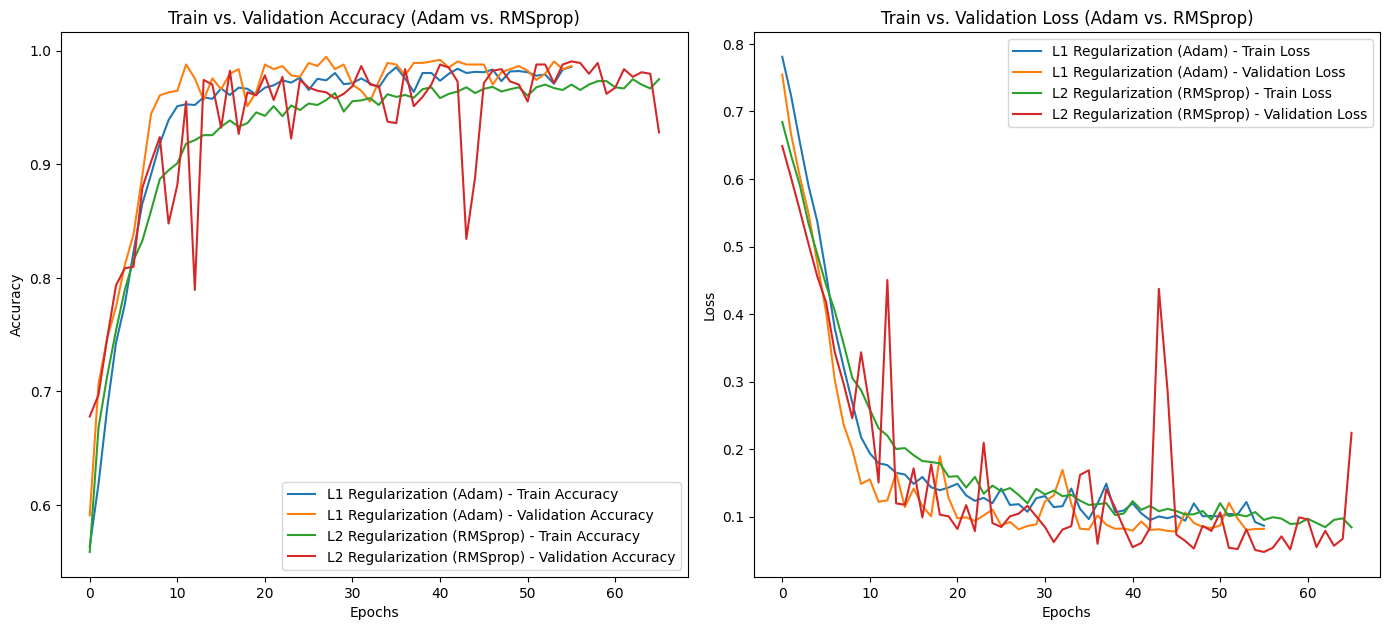

In [57]:
# Function to compare the performance of Adam and RMSprop models
def compare_optimizers(l1_history, l2_history):
    # Setting up the figure size
    plt.figure(figsize=(14, 12))

    # Subplot for training and validation accuracy for both optimizers
    plt.subplot(2, 2, 1)
    plt.plot(l1_history.history['accuracy'], label='L1 Regularization (Adam) - Train Accuracy')
    plt.plot(l1_history.history['val_accuracy'], label='L1 Regularization (Adam) - Validation Accuracy')
    plt.plot(l2_history.history['accuracy'], label='L2 Regularization (RMSprop) - Train Accuracy')
    plt.plot(l2_history.history['val_accuracy'], label='L2 Regularization (RMSprop) - Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Train vs. Validation Accuracy (Adam vs. RMSprop)')
    plt.legend()

    # Subplot for training and validation loss for both optimizers
    plt.subplot(2, 2, 2)
    plt.plot(l1_history.history['loss'], label='L1 Regularization (Adam) - Train Loss')
    plt.plot(l1_history.history['val_loss'], label='L1 Regularization (Adam) - Validation Loss')
    plt.plot(l2_history.history['loss'], label='L2 Regularization (RMSprop) - Train Loss')
    plt.plot(l2_history.history['val_loss'], label='L2 Regularization (RMSprop) - Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Train vs. Validation Loss (Adam vs. RMSprop)')
    plt.legend()

    # Display the plots
    plt.tight_layout()
    plt.show()

# Call the function to compare the two models
compare_optimizers(history_l1, l2_history)


# Initial Results Analyis and Model comparison
In this project, we successfully predicted the potential of music tracks using machine learning techniques. We built and evaluated three models: a vanilla neural network, L1 and L2 regularized neural network. We analyzed their performances and demonstrated improvements in the regularized models regarding regularization and performance metrics.


## Key Observations and model records:
We will analyze the initial results from different models (Vanilla, L1 Regularized, L2 Regularized) and compare
their performance based on various metrics. This will help identify the best-performing model.


**1. Vanilla Model:**
* Test Loss: 0.1350 worst of all the model
* Test Accuracy: 94.89%, which is the lowest among the models.
* Precision: 90.94%, indicating that the model has a relatively higher rate of false positives.
* Recall: 100%, showing the model identifies all true positives, but at the cost of slightly lower Specificity (89.51%).
* F1 Score: 95.26%, which reflects a decent balance between precision and recall, though still lower than the regularized models.

**2. L1 Regularized Model:**

* Test Loss: 0.1021, better than the vanilla model.
* Accuracy: 98.04%, a significant improvement from the vanilla model.
* Precision: 98.92%, the highest among the models, indicating fewer false positives.
* Recall: 97.25%, lower than the vanilla model but much better overall balance with precision.
* Specificity: 98.88%, which is excellent, showing the model is good at distinguishing between classes.
* F1 Score: 98.08%, demonstrating a well-balanced performance between precision and recall.

**3. L2 Regularized Model:**

* Test Loss: 0.0649, the lowest among the models, indicating that this model fits the data better.
* Accuracy: 98.15%, slightly higher than the L1 model, making it the best-performing model overall.
* Precision: 98.30%, slightly lower than L1 but still excellent.
* Recall: 98.09%, the highest among the regularized models, reflecting a better balance between true positives and false negatives.
* Specificity: 98.21%, slightly lower than the L1 model, but still very strong.
* F1 Score: 98.20%, the highest, showing a balanced performance in both precision and recall.

Given:
Best Model Accuracy (L2 Model): 98.15% (or 0.9815)
Simple Model (Vanilla) Accuracy (Vanilla Model): 94.89% (or 0.9489)

Percentage difference [(0.9815−0.9489)/0.9489)] ×100

The validation accuracy of the best-performing model (L2 model) is approximately **3.44%** higher than that of the simple model (vanilla model).


**Conclusion:**

L2 Regularization with RMSprop gives the best overall performance across most metrics, including test loss, accuracy, recall, and F1 score, making it the most well-rounded model.
L1 Regularization shows slightly higher precision and specificity but has a slightly lower recall compared to the L2 model.
The Vanilla Model, while performing decently, lags behind the regularized models in almost every aspect, particularly in handling false positives (precision) and the test loss.

The L2 Regularized Model with RMSprop is the best performing fit for my project.

**Note**: The performance metrics presented are from the initial execution of the notebook. Due to Colab runtime disconnections, re-running the cells led to slightly different results. However, the L2 regularized model consistently outperformed the others in both runs.